# Sentiment Analysis

### Imports

In [1]:
import os
import re
import json
import emoji
import string
import warnings
import numpy as np 
import contractions
import pandas as pd 

warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import FastText

### Loading Dataset
Dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [2]:
df = pd.read_csv('dataset/IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Removing for null and Deuplicated values

In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df = df.drop_duplicates()

## Lable Encoding target

In [5]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [6]:
# LE = lable encoded
lable_map = {
    'positive' : 1,
    'negative' : 0
}
df['sentiment_LE'] = df['sentiment'].map(lable_map)
df

,review,sentiment,sentiment_LE
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [7]:
df['sentiment_LE'].value_counts()

sentiment_LE
1    24884
0    24698
Name: count, dtype: int64

## Removig
1. HTML Tags
2. Expand contractions
3. Emoji handling
4. Spelling correction
5. Lowercase + remove extra spaces
6. Tokenization + lemmatization
7. Negation handling

In [8]:
n = 20
df['review'][n]

"After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a .....' movies cashed in on the wrong guy, wrong place, wrong time concept. That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.<br /><br />Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills. All in all it's full of excuses to dismiss the film as one overblown pile of junk. Stallone even managed to get out-acted by a horse! However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.<br /><br />You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat' agent, Rex Linn as Travers

In [9]:
# Stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Custom stopwords
custom_stop_words = {"movie", "film"}

# Negations
negations = {
    "aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
    "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
    "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
    "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
    "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing",
    "nowhere", "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
    "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't", "without",
    "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"
}

# Remove negations from stopwords
stop_words = (stop_words - negations).union(custom_stop_words)

# Optional lightweight spelling fixes
common_corrections = {
    'moovie': 'movie',
    'actrs': 'actor',
    'amaziing': 'amazing',
    'dissapointng': 'disappointing',
    'wa': 'was'
}
with open("common_corrections.json") as f:
    corrections_dict = json.load(f)

def preprocess_text(text, remove_stop_words=True, negation_combine=True, remove_numbers=True):
    # 1. Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. Expand contractions
    text = contractions.fix(text)
    
    # 3. Convert emojis to text
    text = emoji.demojize(text)
    
    # 4. Lowercase and remove extra spaces
    text = re.sub(r'\s+', ' ', text.lower()).strip()
    
    # 5. Tokenize
    tokens = re.findall(r'\b\w+\b', text)
    
    clean_tokens = []
    for tok in tokens:
        # 6a. Apply lightweight custom spelling correction
        tok = common_corrections.get(tok, tok)
        
        # 6b. Normalize repeated characters: loooove -> loove
        tok = re.sub(r'(.)\1{2,}', r'\1\1', tok)
        
        # 6c. Remove stopwords, custom stopwords, numbers
        if remove_stop_words and tok in stop_words:
            continue
        if remove_numbers and tok.isdigit():
            continue
        
        # 6d. Lemmatize verbs (handles 'was' -> 'be', 'did' -> 'do')
        tok = lemmatizer.lemmatize(tok, pos='v')
        
        clean_tokens.append(tok)
    
    # 7. Handle negations (combine with next word)
    if negation_combine:
        combined_tokens = []
        i = 0
        while i < len(clean_tokens):
            if clean_tokens[i] in negations and i < len(clean_tokens) - 1:
                combined_tokens.append(clean_tokens[i] + "_" + clean_tokens[i+1])
                i += 2
            else:
                combined_tokens.append(clean_tokens[i])
                i += 1
        clean_tokens = combined_tokens
    
    return clean_tokens


# Example usage
sample_text = "<p>I didn't like this movie at all! 😡!!! The moovie was abolutly amaziing but the actrs were dissapointng. rated 10/10!</p>"

preprocess_text(sample_text, remove_stop_words=False, negation_combine=True)

['i',
 'do',
 'not_like',
 'this',
 'movie',
 'at',
 'all',
 'enraged_face',
 'the',
 'movie',
 'be',
 'abolutly',
 'amaze',
 'but',
 'the',
 'actor',
 'be',
 'disappoint',
 'rat']

In [10]:
%%time
preprocess_text(df['review'][n]), df['review'][n]

CPU times: total: 0 ns
Wall time: 10.2 ms


(['success',
  'die',
  'hard',
  'sequels',
  'surprise',
  'really',
  '1990s',
  'glut',
  'die',
  'hard',
  'movies',
  'cash',
  'wrong',
  'guy',
  'wrong',
  'place',
  'wrong',
  'time',
  'concept',
  'cliffhanger',
  'die',
  'hard',
  'mountain',
  'time',
  'rescue',
  'sly',
  'stop',
  'mom',
  'shoot',
  'stallone',
  'career',
  'cliffhanger',
  'one',
  'big',
  'nit',
  'pickers',
  'dream',
  'especially',
  'expert',
  'mountain',
  'climb',
  'base',
  'jump',
  'aviation',
  'facial',
  'expressions',
  'act',
  'skills',
  'full',
  'excuse',
  'dismiss',
  'one',
  'overblown',
  'pile',
  'junk',
  'stallone',
  'even',
  'manage',
  'get',
  'act',
  'horse',
  'however',
  'forget',
  'nonsense',
  'actually',
  'lovable',
  'undeniably',
  'entertain',
  'romp',
  'deliver',
  'plenty',
  'thrill',
  'unintentionally',
  'plenty',
  'laugh',
  'get',
  'love',
  'john',
  'lithgows',
  'sneery',
  'evilness',
  'tick',
  'every',
  'box',
  'band',
  'baddi

In [11]:
df['processed_review'] = df['review'].apply(preprocess_text)

In [12]:
df['processed_review'][n]

['success',
 'die',
 'hard',
 'sequels',
 'surprise',
 'really',
 '1990s',
 'glut',
 'die',
 'hard',
 'movies',
 'cash',
 'wrong',
 'guy',
 'wrong',
 'place',
 'wrong',
 'time',
 'concept',
 'cliffhanger',
 'die',
 'hard',
 'mountain',
 'time',
 'rescue',
 'sly',
 'stop',
 'mom',
 'shoot',
 'stallone',
 'career',
 'cliffhanger',
 'one',
 'big',
 'nit',
 'pickers',
 'dream',
 'especially',
 'expert',
 'mountain',
 'climb',
 'base',
 'jump',
 'aviation',
 'facial',
 'expressions',
 'act',
 'skills',
 'full',
 'excuse',
 'dismiss',
 'one',
 'overblown',
 'pile',
 'junk',
 'stallone',
 'even',
 'manage',
 'get',
 'act',
 'horse',
 'however',
 'forget',
 'nonsense',
 'actually',
 'lovable',
 'undeniably',
 'entertain',
 'romp',
 'deliver',
 'plenty',
 'thrill',
 'unintentionally',
 'plenty',
 'laugh',
 'get',
 'love',
 'john',
 'lithgows',
 'sneery',
 'evilness',
 'tick',
 'every',
 'box',
 'band',
 'baddies',
 'best',
 'permanently',
 'harass',
 'hapless',
 'turncoat',
 'agent',
 'rex',
 '

## Word clouds

In [13]:
all_raw_text = ' '.join(df['review'].astype(str))
all_cleaned_text = ' '.join(df['processed_review'].astype(str))

all_pos_raw_text = ' '.join(df.loc[df['sentiment_LE'] == 1, 'review'].astype(str))
all_neg_raw_text = ' '.join(df.loc[df['sentiment_LE'] == 0, 'review'].astype(str))

all_pos_cleaned_text = ' '.join(df.loc[df['sentiment_LE'] == 1, 'processed_review'].astype(str))
all_neg_cleaned_text = ' '.join(df.loc[df['sentiment_LE'] == 0, 'processed_review'].astype(str))

### Raw reviwes

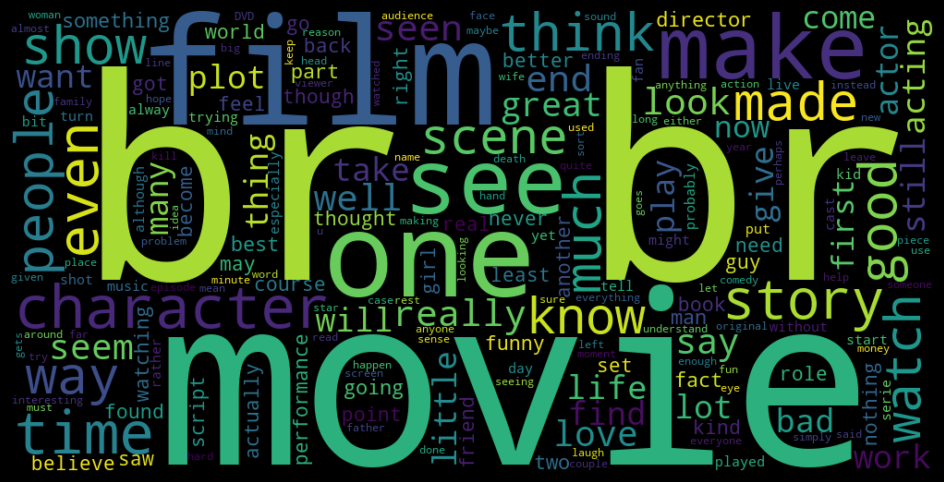

In [14]:
## raw text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='black',
    max_words=200
).generate(all_raw_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
del all_raw_text

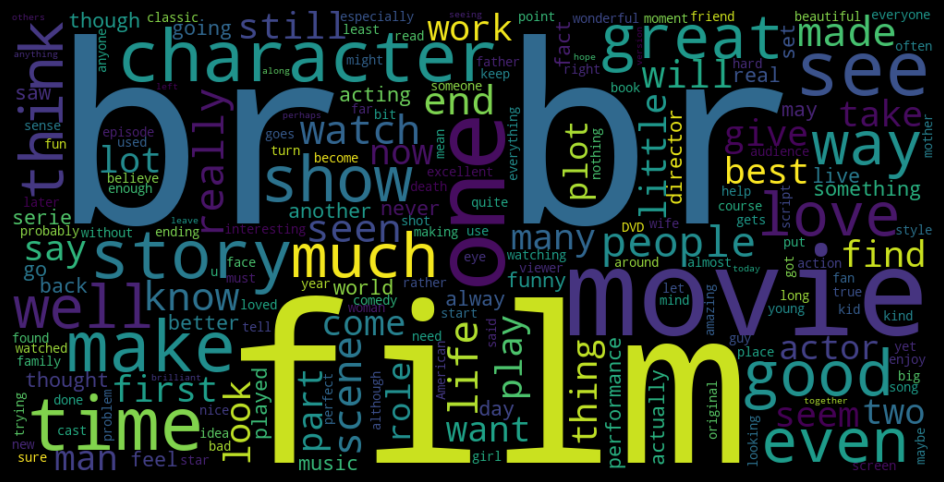

In [16]:
## all_pos_raw_text text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='black',
    max_words=200
).generate(all_pos_raw_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
del all_pos_raw_text

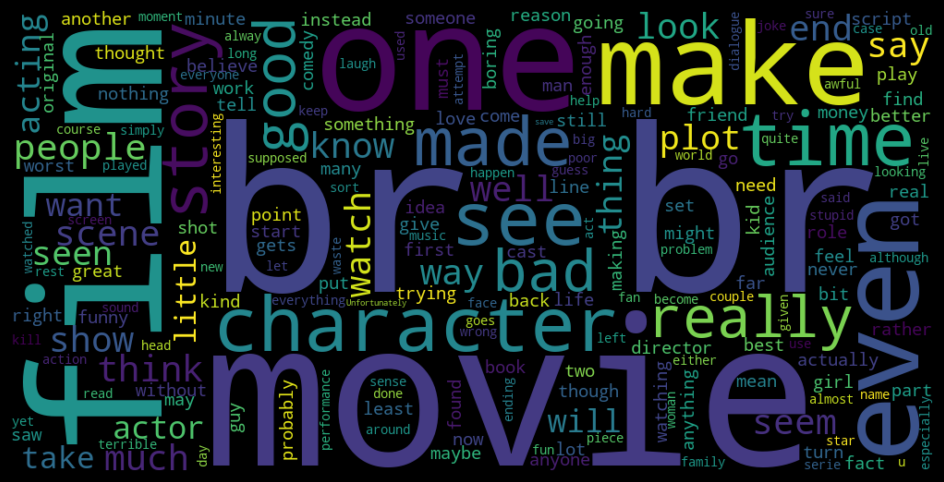

In [18]:
## all_neg_raw_text text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='black',
    max_words=200
).generate(all_neg_raw_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
del all_neg_raw_text

### Preped reviwes

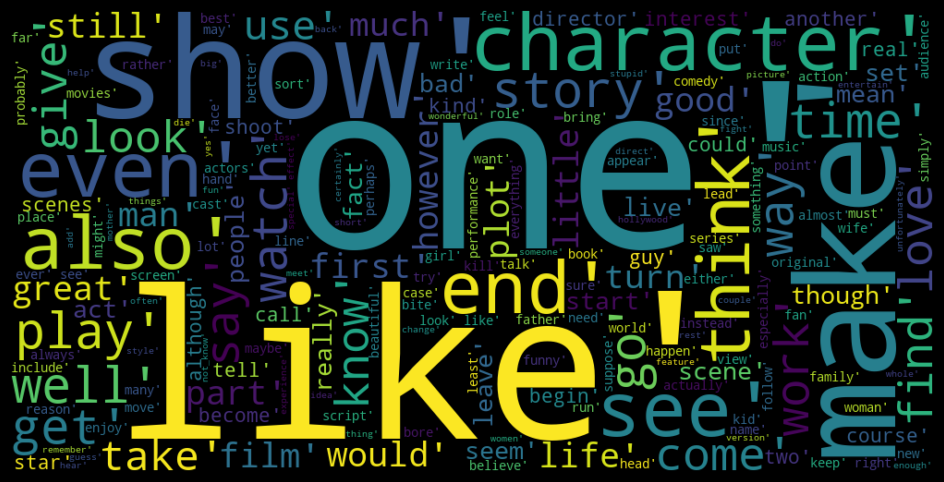

In [20]:
## cleaned text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color="black",
    max_words=200
).generate(all_cleaned_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
del all_cleaned_text

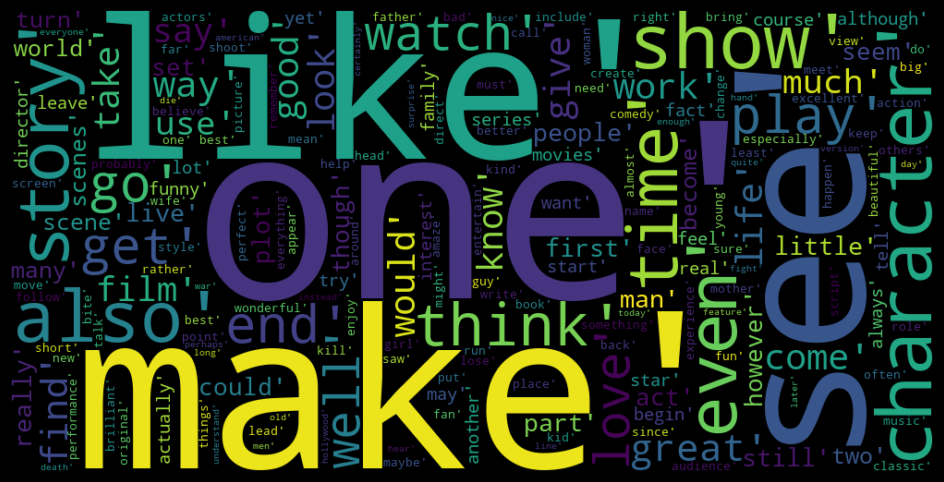

In [22]:
## all_pos_cleaned_text text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='black',
    max_words=200
).generate(all_pos_cleaned_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
del all_pos_cleaned_text

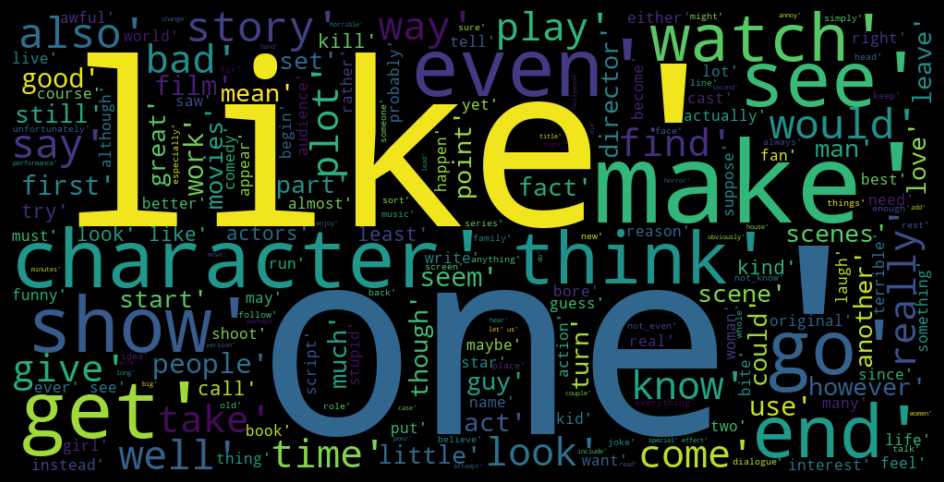

In [24]:
## all_neg_cleaned_text text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='black',
    max_words=200
).generate(all_neg_cleaned_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
del all_neg_cleaned_text

## Countig number of words

In [26]:
df['processed_review_word_len'] = df['processed_review'].apply(len)
df['processed_review_word_len']

0        161
1         86
2         84
3         59
4        122
        ... 
49995     71
49996     56
49997    111
49998    111
49999     59
Name: processed_review_word_len, Length: 49582, dtype: int64

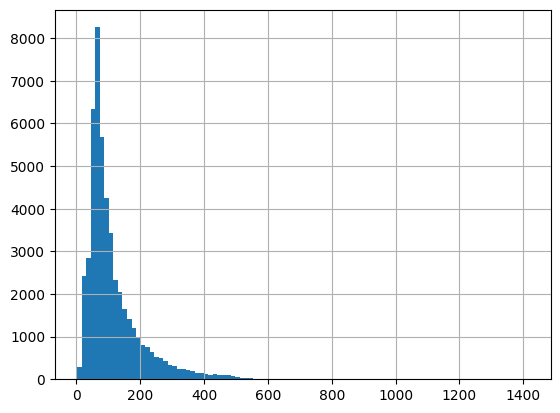

In [27]:
df['processed_review_word_len'].hist(bins=100)
plt.show()

In [28]:
df[df['processed_review_word_len'] == 10]

,review,sentiment,sentiment_LE,processed_review,processed_review_word_len
8146,"Were I not with friends, and so cheap, I would...",negative,0,"[not_friends, cheap, would, walk, fail, misera...",10
15009,If you've ever had a mad week-end out with you...,positive,1,"[ever, mad, week, end, mat, appreciate, excell...",10
17855,This was an incredibly stupid movie. It was po...,negative,0,"[incredibly, stupid, possibly, worst, ever, di...",10
35821,Brilliant movie. The drawings were just amazin...,positive,1,"[brilliant, drawings, amaze, bad, end, begin, ...",10
39867,This is a very cool movie. The ending of the m...,positive,1,"[cool, end, bite, define, play, end, either, w...",10
43607,Absolutely fantastic! Whatever I say wouldn't ...,positive,1,"[absolutely, fantastic, whatever, say, would, ...",10
43692,I thought this was a quiet good movie. It was ...,positive,1,"[think, quiet, good, fun, watch, like, best, o...",10


## counting positive and negative words

In [29]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

def count_positive_words(words):
    return sum(1 for w in words if w in positive_words)

def count_negative_words(words):
    return sum(1 for w in words if w in negative_words)

In [30]:
n = 8416
df['processed_review'][n], df['sentiment'][n]

(['ok',
  'first',
  'saw',
  'like',
  'cinemax',
  'weeks',
  'ago',
  'think',
  'would',
  'award',
  'win',
  'boy',
  '180d',
  'bite',
  'big',
  'one',
  'mean',
  'mother',
  'monsters',
  'show',
  'true',
  'form',
  'end',
  'go',
  'not_show',
  'briefly',
  'little',
  'bite',
  'earlier',
  'plot',
  'mother',
  'son',
  'feast',
  'blood',
  'young',
  'women',
  'would',
  'not_better',
  'go',
  'know',
  'kill',
  'spree',
  'kill',
  'like',
  'couple',
  'young',
  'women',
  'sheriff',
  'cop',
  'find',
  'get',
  'old',
  'find',
  'way',
  'kill',
  'monsters',
  'save',
  'young',
  'woman',
  'women',
  'people',
  'kill',
  'process',
  'think',
  'would',
  'hell',
  'lot',
  'better',
  'way',
  'also',
  'suck',
  'son',
  'main',
  'character',
  'get',
  'kill',
  'first',
  'not_get',
  'rid',
  'mother',
  'first',
  'plus',
  'strength',
  'end',
  'start',
  'kill',
  'people',
  'say',
  'weak',
  'heck',
  'wrong',
  'stephen',
  'time',
  'never_

In [31]:
pos = count_positive_words(df['processed_review'][n])
neg = count_negative_words(df['processed_review'][n])
pos, neg

(6, 12)

In [32]:
i = 1
for w in df['processed_review'][n]:
    if w in positive_words: 
        print(i, "p:", w)
        i += 1
print()
i = 1
for w in df['processed_review'][n]:
    if w in negative_words: 
        print(i, "n:", w)
        i += 1

1 p: like
2 p: award
3 p: win
4 p: like
5 p: better
6 p: best

1 n: plot
2 n: kill
3 n: kill
4 n: kill
5 n: kill
6 n: hell
7 n: suck
8 n: kill
9 n: kill
10 n: weak
11 n: heck
12 n: wrong


In [33]:
pos_counts = df['processed_review'].apply(count_positive_words)
pos_counts

0        12
1        10
2         9
3         2
4        13
         ..
49995    13
49996     3
49997     7
49998     7
49999     4
Name: processed_review, Length: 49582, dtype: int64

In [34]:
neg_counts = df['processed_review'].apply(count_negative_words)
neg_counts

0        19
1         2
2         7
3         7
4         3
         ..
49995     2
49996    11
49997    13
49998    16
49999     7
Name: processed_review, Length: 49582, dtype: int64

In [35]:
pos_neg_ratio = pos_counts / neg_counts
pos_neg_ratio

0        0.631579
1        5.000000
2        1.285714
3        0.285714
4        4.333333
           ...   
49995    6.500000
49996    0.272727
49997    0.538462
49998    0.437500
49999    0.571429
Name: processed_review, Length: 49582, dtype: float64

In [36]:
df['pos_neg_ratio'] = pos_neg_ratio
del pos_neg_ratio
df['pos_counts'] = pos_counts
del pos_counts
df['neg_counts'] = neg_counts
del neg_counts

In [37]:
df[['sentiment', 'pos_neg_ratio', 'pos_counts', 'neg_counts']]

,sentiment,pos_neg_ratio,pos_counts,neg_counts
0,positive,0.631579,12,19
1,positive,5.000000,10,2
2,positive,1.285714,9,7
3,negative,0.285714,2,7
4,positive,4.333333,13,3
...,...,...,...,...
49995,positive,6.500000,13,2
49996,negative,0.272727,3,11
49997,negative,0.538462,7,13
49998,negative,0.437500,7,16


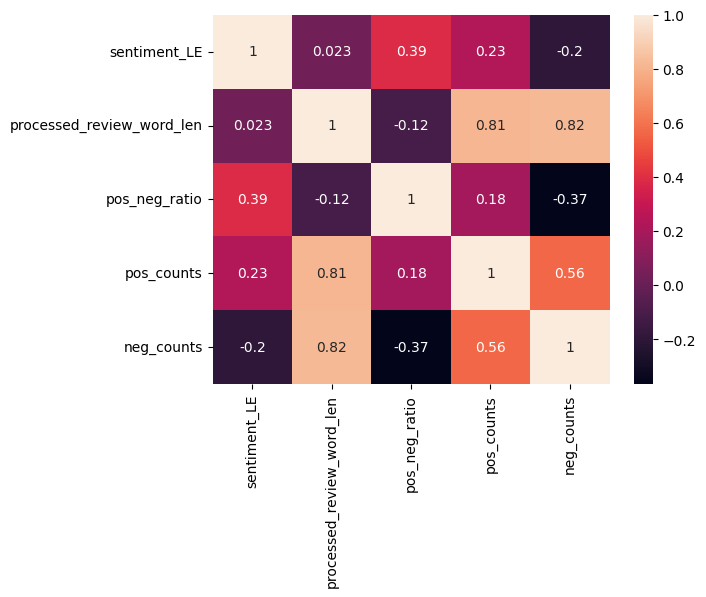

In [38]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

In [39]:
df['processed_review'] = df['processed_review'].apply(lambda x: ' '.join(x))
df.to_csv('dataset/preped/preped_new_df.csv', index=False)

## TfidfVectorizer

In [2]:
df = pd.read_csv('dataset/preped/preped_new_df.csv')
df

,review,sentiment,sentiment_LE,processed_review,processed_review_word_len,pos_neg_ratio,pos_counts,neg_counts
0,One of the other reviewers has mentioned that ...,positive,1,one reviewers mention watch oz episode hook ri...,161,0.631579,12,19
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production film technique una...,86,5.000000,10,2
2,I thought this was a wonderful way to spend ti...,positive,1,think wonderful way spend time hot summer week...,84,1.285714,9,7
3,Basically there's a family where a little boy ...,negative,0,basically family little boy jake think zombie ...,59,0.285714,2,7
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love time money visually stun wa...,122,4.333333,13,3
...,...,...,...,...,...,...,...,...
49577,I thought this movie did a down right good job...,positive,1,think right good job not_creative original fir...,71,6.500000,13,2
49578,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,bad plot bad dialogue bad act idiotic direct a...,56,0.272727,3,11
49579,I am a Catholic taught in parochial elementary...,negative,0,catholic teach parochial elementary school nun...,111,0.538462,7,13
49580,I'm going to have to disagree with the previou...,negative,0,go disagree previous comment side maltin one s...,111,0.437500,7,16


In [43]:
tfid = TfidfVectorizer(
    max_features=20000, 
    min_df=10,
    ngram_range=(1,3),
    sublinear_tf=True
)
tfid_vecs = tfid.fit_transform(df['processed_review']).astype('float32')

In [44]:
tfid_vecs.get_shape()

(49582, 20000)

In [45]:
tfid.get_feature_names_out()

array(['11th', '13th', '16mm', ..., 'zu', 'zucco', 'zucker'], dtype=object)

In [50]:
tfid_df = pd.DataFrame(tfid_vecs.toarray(), index=df.index, columns=tfid.get_feature_names_out())
tfid_df['sentiment_LE'] = df['sentiment_LE']
tfid_df['pos_neg_ratio'] = df['pos_neg_ratio']
tfid_df['processed_review_word_len'] = df['processed_review_word_len']
tfid_df['review'] = df['review']
tfid_df['processed_review'] = df['processed_review']
tfid_df

,11th,13th,16mm,18th,18th century,1920s,1930s,1940s,1950s,1960s,...,zoo,zoom,zorro,zu,zucco,zucker,sentiment_LE,pos_neg_ratio,processed_review_word_len,processed_review
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.631579,161,one reviewers mention watch oz episode hook ri...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,5.000000,86,wonderful little production film technique una...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.285714,84,think wonderful way spend time hot summer week...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.285714,59,basically family little boy jake think zombie ...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.333333,122,petter mattei love time money visually stun wa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,6.500000,71,think right good job not_creative original fir...
49578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.272727,56,bad plot bad dialogue bad act idiotic direct a...
49579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.538462,111,catholic teach parochial elementary school nun...
49580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.437500,111,go disagree previous comment side maltin one s...


In [52]:
tfid_df.to_csv('dataset/preped/tfid_df_max_feature=20000_min_df=10_ngram_range=(1,3)_sublinear_tf=True.csv', index=False)
del tfid_df

In [53]:
del tfid, tfid_vecs

In [3]:
# number of rows per chunk
chunksize = 10000
n = 20  

# accumulators
pos_sum = None
neg_sum = None

use_cols = None  # to fix column order after first chunk

for chunk in pd.read_csv('dataset/preped/tfid_df_max_feature=20000_min_df=10_ngram_range=(1,3)_sublinear_tf=True.csv', chunksize=chunksize):
    if use_cols is None:
        use_cols = [c for c in chunk.columns if c not in ['sentiment_LE', 'pos_neg_ratio', 'pos_counts', 'neg_counts', 'review', 'sentiment', 'processed_review',	'processed_review_word_len']]
        pos_sum = pd.Series(0, index=use_cols, dtype='float32')
        neg_sum = pd.Series(0, index=use_cols, dtype='float32')

    # positive rows
    pos_rows = chunk[chunk['sentiment_LE'] == 1][use_cols]
    pos_sum = pos_sum.add(pos_rows.sum(axis=0), fill_value=0)

    # negative rows
    neg_rows = chunk[chunk['sentiment_LE'] == 0][use_cols]
    neg_sum = neg_sum.add(neg_rows.sum(axis=0), fill_value=0)

# take top-N
pos_word_freq = pos_sum.sort_values(ascending=False).head(n)
neg_word_freq = neg_sum.sort_values(ascending=False).head(n)

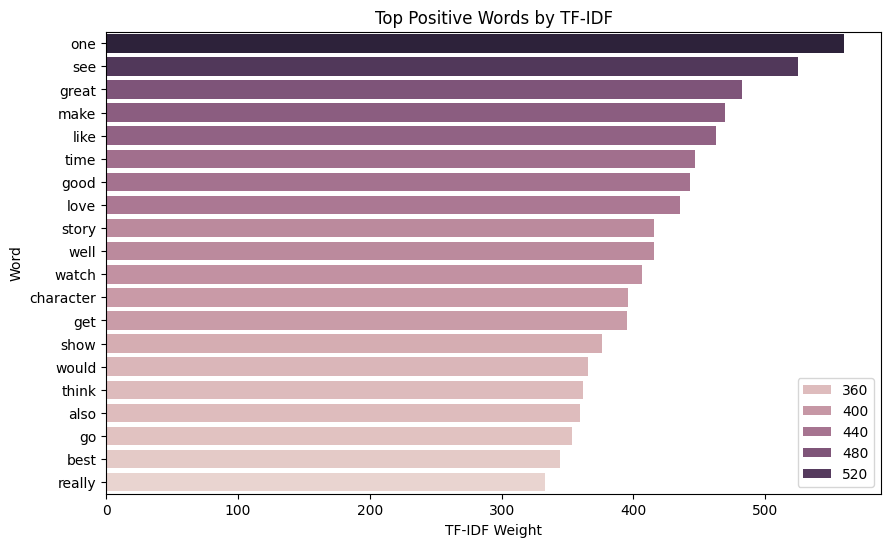

In [4]:
# Plot Positive words
plt.figure(figsize=(10, 6))
sns.barplot(x=pos_word_freq.values, y=pos_word_freq.index, hue=pos_word_freq.values)
plt.title("Top Positive Words by TF-IDF")
plt.xlabel("TF-IDF Weight")
plt.ylabel("Word")
plt.show()

In [5]:
del pos_word_freq

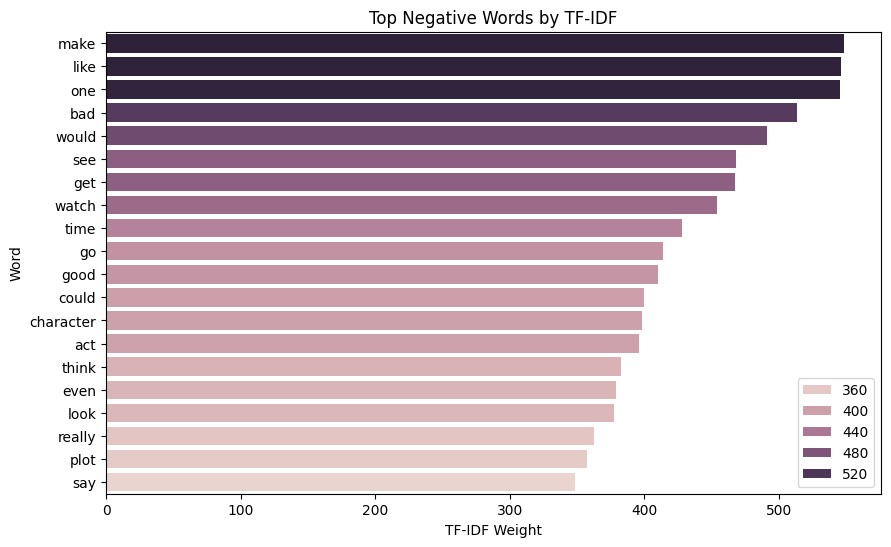

In [6]:
# Plot Negative words
plt.figure(figsize=(10, 6))
sns.barplot(x=neg_word_freq.values, y=neg_word_freq.index, hue=neg_word_freq.values)
plt.title("Top Negative Words by TF-IDF")
plt.xlabel("TF-IDF Weight")
plt.ylabel("Word")
plt.show()

In [7]:
del neg_word_freq

## Word2vec

In [8]:
df = pd.read_csv('dataset/preped/preped_df.csv')

In [9]:
sentences = [sentence.split() for sentence in df['processed_review']]
sentences[0]

['reviewer',
 'mention',
 'watch',
 '1',
 'oz',
 'episode',
 'hook',
 'right',
 'exactly',
 'happen',
 'me.the',
 'strike',
 'oz',
 'brutality',
 'unflinche',
 'violence',
 'set',
 'right',
 'word',
 'trust',
 'faint',
 'hearted',
 'timid',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word.it',
 'call',
 'oz',
 'nickname',
 'give',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focus',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inward',
 'privacy',
 'high',
 'agenda',
 'city',
 'home',
 'aryan',
 'muslim',
 'gangsta',
 'latinos',
 'christians',
 'italian',
 'irish',
 'scuffle',
 'death',
 'stare',
 'dodgy',
 'dealing',
 'shady',
 'agreement',
 'far',
 'away.i',
 'main',
 'appeal',
 'fact',
 'go',
 'dare',
 'forget',
 'pretty',
 'picture',
 'paint',
 'mainstream',
 'audience',
 'forget',
 'charm',
 'forget',
 'romance',
 'oz',
 'mess',
 'episode',
 'see

In [22]:
w2v = Word2Vec(sentences=sentences, vector_size=300, window=12, min_count=5, sg=1, epochs=12, workers=4)

In [23]:
w2v.save('models/w2v/word2vac_vector_size=300_window=12_min_count=5_sg=1_epochs=12_workers=4.model')

In [24]:
w2v.wv.most_similar('smart')

[('aleck', 0.573418378829956),
 ('alecky', 0.5107160210609436),
 ('intelligent', 0.49174147844314575),
 ('sucked.the', 0.4203316271305084),
 ('all', 0.4200204908847809),
 ('fixit', 0.4134148359298706),
 ('stupid', 0.4081323444843292),
 ('dumb', 0.3974463641643524),
 ('klasky', 0.3907173275947571),
 ('think', 0.3904150128364563)]

In [25]:
w2v.wv.most_similar("good")

[('great', 0.7669091820716858),
 ('well', 0.7056183815002441),
 ('like', 0.7053687572479248),
 ('think', 0.6846379041671753),
 ('bad', 0.6468538641929626),
 ('pretty', 0.6437553763389587),
 ('especially', 0.6358663439750671),
 ('excellent', 0.6306958198547363),
 ('decent', 0.6239669322967529),
 ('nice', 0.6239272952079773)]

In [66]:
w2v.wv.most_similar(positive=["king", "girl"], negative=["boy"])

[('sheeba', 0.40249118208885193),
 ('lear', 0.38885390758514404),
 ('queen', 0.3826269507408142),
 ('adeline', 0.370458722114563),
 ('zheng', 0.358801007270813),
 ('1½', 0.35531941056251526),
 ('shepherdess', 0.3463297486305237),
 ('vidor', 0.3439827561378479),
 ('ghidorah', 0.34094783663749695),
 ('verdon', 0.33997100591659546)]

In [57]:
w2v.wv.similarity("king", "girl"), w2v.wv.similarity("queen", "girl") 

(0.10045332, 0.22004348)

In [67]:
r = w2v.wv['king'] - w2v.wv['boy'] + w2v.wv['girl']
w2v.wv.similar_by_vector(r)

[('king', 0.8443096876144409),
 ('sheeba', 0.439801961183548),
 ('lear', 0.42802518606185913),
 ('1½', 0.41220924258232117),
 ('zheng', 0.41081252694129944),
 ('ghidorah', 0.409911572933197),
 ('queen', 0.3998895585536957),
 ('vidor', 0.38610103726387024),
 ('shepherdess', 0.3806209862232208),
 ('adeline', 0.379604309797287)]

In [29]:
rng = np.random.default_rng(42)
pad_vec = rng.normal(scale=0, size=w2v.vector_size).astype(np.float32)
oov_vec = rng.normal(scale=0.01, size=w2v.vector_size).astype(np.float32)

np.save('embeddings/pad_vec.npy', pad_vec)
np.save('embeddings/oov_vec.npy', oov_vec) 

In [30]:
def get_w2v_padded_embeddings(sentence, max_words):
    model = w2v
    embedding_dim = model.vector_size
    embeddings = []
    
    for word in sentence:
        # in vocab
        if word in model.wv:
            embeddings.append(model.wv[word])
        # out of vocab
        else:
            embeddings.append(oov_vec)

    # tuncate
    if len(embeddings) > max_words:
        embeddings = embeddings[:max_words]
    # paddinf
    else:
        while len(embeddings) < max_words:
            embeddings.append(pad_vec)

    return np.array(embeddings)

In [31]:
a = get_w2v_padded_embeddings('absolutly hate coding'.split(), max_words=4)
a

array([[ 0.03012205, -0.05070116,  0.04578048, ..., -0.00397047,
         0.04306644,  0.06882008],
       [ 0.20774335,  0.1106528 , -0.07941765, ...,  0.17455672,
        -0.2084361 ,  0.04000758],
       [ 0.0172735 , -0.01533861,  0.00863828, ...,  0.00812601,
         0.0024166 , -0.01774962],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [32]:
np.array_equal(a[2], oov_vec), np.array_equal(a[3], pad_vec)

(True, True)

In [33]:
get_w2v_padded_embeddings(sentences[0], max_words=100)

array([[ 0.0427512 ,  0.3132069 , -0.06385662, ...,  0.07051571,
         0.1224346 , -0.11609727],
       [-0.0626334 ,  0.04999569, -0.07202432, ..., -0.06097156,
         0.08341526,  0.05981042],
       [ 0.08043394,  0.01511925, -0.01751697, ...,  0.04313497,
        -0.05181615, -0.05821913],
       ...,
       [ 0.28509045,  0.23372789, -0.06244872, ..., -0.05113549,
         0.04603649, -0.04972899],
       [ 0.08043394,  0.01511925, -0.01751697, ...,  0.04313497,
        -0.05181615, -0.05821913],
       [ 0.01651162,  0.071931  , -0.08209104, ...,  0.0404711 ,
         0.21100707, -0.19170785]], dtype=float32)

## FastText 

In [34]:
ft = FastText(sentences=sentences, vector_size=300, window=12, min_count=5, sg=1, epochs=12, workers=4)

In [35]:
ft.save('models/FastText/FastText_vector_size=300_window=12_min_count=5_sg=1_epochs=12_workers=4.model')

In [36]:
ft.wv.most_similar('smart')

[('outsmart', 0.5538058876991272),
 ('smartly', 0.5272572636604309),
 ('intelligent', 0.47381171584129333),
 ('alecky', 0.43652790784835815),
 ('stupid', 0.42385756969451904),
 ('clever', 0.4228117763996124),
 ('aleck', 0.4219425618648529),
 ('dumb.the', 0.41643351316452026),
 ('ass', 0.4103288948535919),
 ('dumb.i', 0.409977525472641)]

In [37]:
ft.wv.most_similar('good')

[('great', 0.7680498361587524),
 ('well', 0.7427987456321716),
 ('like', 0.6942805051803589),
 ('think', 0.6672694087028503),
 ('excellent', 0.6471666097640991),
 ('decent', 0.6408283710479736),
 ('especially', 0.6364725828170776),
 ('pretty', 0.6296836733818054),
 ('bad', 0.6220064163208008),
 ('good.overall', 0.6198676824569702)]

In [38]:
ft.wv.most_similar('bitch')

[('bitchy', 0.7329369187355042),
 ('stritch', 0.44146695733070374),
 ('fitch', 0.4370066523551941),
 ('slutty', 0.4257015585899353),
 ('slut', 0.4253447353839874),
 ('b*tch', 0.4220043122768402),
 ('bitty', 0.41558411717414856),
 ('leitch', 0.4152788519859314),
 ('a**hole', 0.4094771444797516),
 ('obnoxious', 0.3950076699256897)]

In [69]:
ft.wv.most_similar(positive=["king", "female"], negative=["male"])

[('ghidorah', 0.44603073596954346),
 ('kingdom', 0.43044528365135193),
 ('soloman', 0.38928458094596863),
 ('stephen', 0.3776775896549225),
 ('solomon', 0.37482699751853943),
 ('crowning', 0.3720687925815582),
 ('1½', 0.3695283830165863),
 ('triton', 0.3539501428604126),
 ('sheeba', 0.3480418026447296),
 ('dr.who', 0.3464905619621277)]

In [40]:
r = ft.wv['king'] - ft.wv['male'] + ft.wv['female']
ft.wv.similar_by_vector(r)

[('king', 0.8608537316322327),
 ('ghidorah', 0.4552803933620453),
 ('kingdom', 0.4464668929576874),
 ('stephen', 0.4013325572013855),
 ('soloman', 0.40023303031921387),
 ('solomon', 0.3926019072532654),
 ('1½', 0.38909289240837097),
 ('crowning', 0.3721011281013489),
 ('triton', 0.3655540645122528),
 ('vidor', 0.3654398024082184)]

In [41]:
def get_ft_padded_embeddings(sentence, max_words):
    model = ft
    embedding_dim = model.vector_size
    embeddings = []
    
    for word in sentence:
        embeddings.append(model.wv[word])

    # tuncate
    if len(embeddings) > max_words:
        embeddings = embeddings[:max_words]
    # paddinf
    else:
        while len(embeddings) < max_words:
            embeddings.append(pad_vec)

    return np.array(embeddings)

In [42]:
a = get_ft_padded_embeddings('absolutly hate coding'.split(), max_words=4)
a

array([[-0.16346706,  0.25970805,  0.05320203, ...,  0.3045789 ,
         0.03305598, -0.01906586],
       [-0.07421853,  0.14581375, -0.13488269, ..., -0.04298692,
         0.22885132,  0.07024987],
       [-0.20841107, -0.08173855, -0.13947156, ..., -0.11598995,
        -0.17251904,  0.1189807 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [43]:
get_ft_padded_embeddings(sentences[0], max_words=100)

array([[-0.10558596,  0.15476711, -0.10652884, ...,  0.2836407 ,
         0.21653809, -0.00219643],
       [ 0.12175215,  0.10716701, -0.02914751, ..., -0.00715269,
         0.1308197 ,  0.13662371],
       [-0.17613333,  0.15428099, -0.12944475, ..., -0.00412342,
        -0.06412309,  0.08865444],
       ...,
       [ 0.12069451, -0.00448825, -0.4146821 , ..., -0.13020386,
        -0.02529983,  0.21209447],
       [-0.17613333,  0.15428099, -0.12944475, ..., -0.00412342,
        -0.06412309,  0.08865444],
       [ 0.05610846,  0.3457686 , -0.20810917, ...,  0.07601478,
         0.08407818, -0.05375074]], dtype=float32)

## BERT Encoder

In [44]:
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [48]:
text = df['processed_review'][n]

encoded_input = tokenizer.batch_encode_plus( [text],# List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True    # Add special tokens CLS and SEP
)

input_ids = encoded_input['input_ids']  # Token IDs
# print input IDs
print(f"Input ID: {input_ids}")
attention_mask = encoded_input['attention_mask']  # Attention mask
# print attention mask
print(f"Attention mask: {attention_mask}")

Input ID: tensor([[  101,  3112,  3280,  2524,  8297,  4474,  2901,  1043,  7630,  2102,
          3280,  2524,  5356,  3308,  3124,  3308,  2173,  3308,  4145,  7656,
         18003,  2121,  3280,  2524,  3137,  5343, 18230,  2644,  3566,  5607,
         13498,  5643,  2476,  1012,  7656, 18003,  2121,  2502,  9152,  2102,
          4060,  2121,  3959,  2926,  6739,  3137,  8218,  2918,  8660,  5734,
         13268,  3670,  3772,  8066,  8016, 19776,  2058, 16558, 12384,  8632,
         18015, 13498,  5643,  6133,  2552,  3586,  5293, 14652,  2941,  8840,
         12423,  6151, 19825,  6321, 14036, 17083,  2361,  8116,  7564, 16959,
          4895, 18447,  4765, 19301,  2135,  7564, 11680,  1012,  2017,  2131,
          2293,  2198,  5507, 25619, 15568,  1055, 19755,  2100,  4763,  2791,
         16356,  3482,  2316,  2919, 10265,  2204,  8642, 28186,  5292, 21112,
          2015,  2735, 16531,  4005, 10151, 11409,  2078, 29053,  1012,  2002,
          2888,  6533,  7642,  6359,  2745

In [49]:
model = BertModel.from_pretrained("bert-base-uncased")
outputs = model(**encoded_input)
# The embeddings are in the `last_hidden_state` attribute of the outputs
token_embeddings = outputs.last_hidden_state

In [51]:
token_embeddings, token_embeddings.shape

(tensor([[[-0.1187,  0.1571,  0.4871,  ..., -0.3100,  0.1671,  0.1049],
          [ 0.0654,  0.2608,  0.1995,  ..., -0.0604,  0.4735, -0.2793],
          [ 0.2525, -0.3315,  1.2258,  ..., -0.2011, -0.0841,  0.6397],
          ...,
          [ 1.0006,  0.0575,  1.1712,  ..., -0.4443,  0.1521, -0.5528],
          [ 0.9495,  0.1139,  0.7495,  ..., -0.3883,  0.1316, -0.8903],
          [ 0.4657,  0.4093,  0.0101,  ...,  0.0875, -0.2611,  0.2406]]],
        grad_fn=<NativeLayerNormBackward0>),
 torch.Size([1, 199, 768]))

In [53]:
df['processed_review'][n]

'success die hard sequel surprise 1990 glut die hard cash wrong guy wrong place wrong concept cliffhanger die hard mountain rescue sly stop mom shoot stallone career.cliffhanger big nit picker dream especially expert mountain climbing base jumping aviation facial expression acting skill excuse dismiss overblown pile junk stallone manage act horse forget nonsense actually lovable undeniably entertaining romp deliver plenty thrill unintentionally plenty laughs.you get love john lithgows sneery evilness tick box band baddie good permanently harassed hapless turncoat agent rex linn travers.he henry portrait serial killer michael rooker noteworthy cringe worthy performance hal insist constantly shriek painful disbelief captor hurt whilst surely look like ralph waite frank grin girl plummet death.mention london burning craig fairbrass brit bad guy come cropper whilst hal human football yes help enjoy hal need good kicking.so forget well judgement care happen lower act expectation turn volume